In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report


In [6]:
# Load the data
data = pd.read_csv("C:/Users/Manikandan/Desktop/class/Data Management and Big Data/finalproj/merged_dataset.csv")

# Handling missing values
data['Credit_Product'] = data['Credit_Product'].fillna('No')

# Drop rows where 'Is_Lead' is missing assuming these rows are split between train and test set
data.dropna(subset=['Is_Lead'], inplace=True)

# Label encoding for categorical variables
encoder = LabelEncoder()
categorical_columns = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col])

# Splitting the data into features and target
X = data.drop(['ID', 'Is_Lead'], axis=1)
y = data['Is_Lead']


In [7]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [8]:
log_reg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
grad_boost = GradientBoostingClassifier(random_state=42)

# Fit the models
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
grad_boost.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

In [9]:
log_reg_pred = log_reg.predict(X_test)
rf_pred = rf.predict(X_test)
accuracy_before_tuning = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy Before Hyperparameter Tuning:", accuracy_before_tuning)

grad_boost_pred = grad_boost.predict(X_test)

log_reg_proba = log_reg.predict_proba(X_test)[:, 1]
rf_proba = rf.predict_proba(X_test)[:, 1]
grad_boost_proba = grad_boost.predict_proba(X_test)[:, 1]


Random Forest Accuracy Before Hyperparameter Tuning: 0.7789805677078034


In [11]:
# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hyperparameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Grid Search for Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_
print("Best parameters for Random Forest:", rf_grid_search.best_params_)

# Grid Search for Gradient Boosting
gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
gb_grid_search.fit(X_train, y_train)
best_gb_model = gb_grid_search.best_estimator_
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}


In [ ]:
# Predict using the best Random Forest model
best_rf_predictions = best_rf_model.predict(X_test)
best_rf_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Predict using the best Gradient Boosting model
best_gb_predictions = best_gb_model.predict(X_test)
best_gb_proba = best_gb_model.predict_proba(X_test)[:, 1]

# Evaluate Random Forest model
rf_accuracy = accuracy_score(y_test, best_rf_predictions)
rf_auc = roc_auc_score(y_test, best_rf_proba)
print("Best Random Forest Accuracy:", rf_accuracy)
print("Best Random Forest ROC AUC:", rf_auc)

# Evaluate Gradient Boosting model
gb_accuracy = accuracy_score(y_test, best_gb_predictions)
gb_auc = roc_auc_score(y_test, best_gb_proba)
print("Best Gradient Boosting Accuracy:", gb_accuracy)
print("Best Gradient Boosting ROC AUC:", gb_auc)


Best Random Forest Accuracy: 0.7927154339200325
Best Random Forest ROC AUC: 0.7856313639177385
Best Gradient Boosting Accuracy: 0.7939973547665072
Best Gradient Boosting ROC AUC: 0.7864902721415962


In [12]:
# Model performance comparison
model_accuracies = {
    'Logistic Regression': accuracy_score(y_test, log_reg_pred),
    'Random Forest': rf_accuracy,
    'Gradient Boosting': gb_accuracy
}

model_auc_scores = {
    'Logistic Regression': roc_auc_score(y_test, log_reg_proba),
    'Random Forest': rf_auc,
    'Gradient Boosting': gb_auc
}

# Plot the updated accuracies
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.bar(model_auc_scores.keys(), model_auc_scores.values(), color='salmon')
plt.title('Model ROC AUC')
plt.ylabel('ROC AUC')

# Updated ROC curves
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_test, best_gb_proba)

plt.subplot(2, 2, 3)
plt.plot(fpr_log_reg, tpr_log_reg, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# Confusion matrix for the best Gradient Boosting model
plt.subplot(2, 2, 4)
conf_matrix = confusion_matrix(y_test, best_gb_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()


NameError: name 'rf_accuracy' is not defined

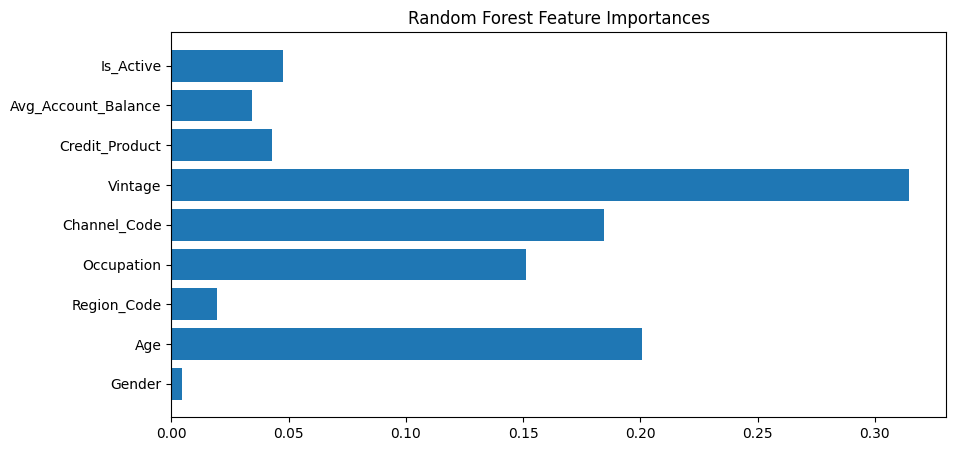

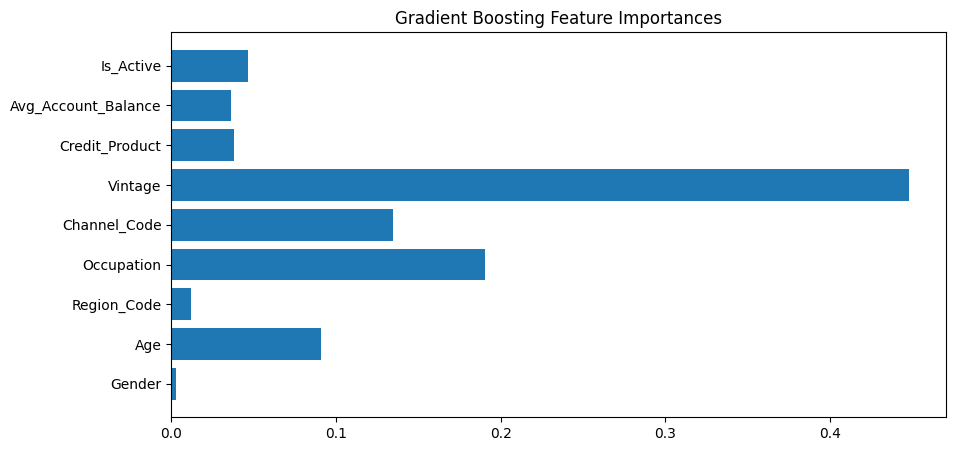

In [13]:
# Feature importance for the best Random Forest model
plt.figure(figsize=(10, 5))
plt.barh(X.columns, best_rf_model.feature_importances_)
plt.title('Random Forest Feature Importances')
plt.show()

# Feature importance for the best Gradient Boosting model
plt.figure(figsize=(10, 5))
plt.barh(X.columns, best_gb_model.feature_importances_)
plt.title('Gradient Boosting Feature Importances')
plt.show()


In [14]:
# Print the predicted values of Is_Lead for the test set using the best Gradient Boosting model
print("Predicted values of Is_Lead for the test set using the best Gradient Boosting model:")
print(best_gb_predictions)

Predicted values of Is_Lead for the test set using the best Gradient Boosting model:


NameError: name 'best_gb_predictions' is not defined